In [1]:
# matrix with all the gene expression values for a particular condition 

genes, gene lengths, 
observed- gene expressionn values
for neg bino reg model - need parameter for mean expression level and dispersion parameter 
mean expression level can be stratified by catogery

In [1]:
import os

# These MUST come before importing pymc or pytensor
os.environ["PYTENSOR_FLAGS"] = "optimizer_excluding=constant_folding,mode=FAST_RUN,linker=py"
os.environ["PYTENSOR_WARN__C_COMPILE"] = "False"

import pytensor
pytensor.config.cxx = ""

# Now import pymc
import pymc as pm
import arviz as az
print("Linker:", pytensor.config.linker)

import numpy as np
import pandas as pd

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Linker: py


In [2]:
import scanpy as sc
import matplotlib.pyplot  as plt

In [3]:
import pymc as pm
print("PyMC version:", pm.__version__)


PyMC version: 5.12.0


In [4]:
adata = sc.read("merged_dataset.h5ad")

In [5]:
# Print a summary of the dataset
print(adata)

AnnData object with n_obs × n_vars = 186224 × 39241
    obs: 'AvgSpotLen', 'Bases', 'Bytes', 'original_index'


In [6]:
# adata_sub = adata[:500, :100].copy()
adata_sub = adata[:1000, :500].copy()

# Extract raw count matrix (dense format)
# Convert to dense array if needed
if not isinstance(adata_sub.X, np.ndarray):
    counts = adata_sub.X.toarray()
else:
    counts = adata_sub.X
# Transpose to get (n_genes, n_cells)
observed_counts = counts.T.astype(int)
n_genes, n_conditions = observed_counts.shape  # "conditions" are cells

In [7]:
# Simulate realistic sequencing depth if NaN
if 'Bases' in adata_sub.obs.columns:
    # Generate simulated values for missing entries (e.g., log-normal)
    missing_mask = adata_sub.obs['Bases'].isna()
    simulated_bases = np.random.lognormal(mean=10, sigma=0.5, size=missing_mask.sum())
    adata_sub.obs.loc[missing_mask, 'Bases'] = simulated_bases

    # Convert to numeric and drop any remaining invalids just in case
    adata_sub.obs['Bases'] = pd.to_numeric(adata_sub.obs['Bases'], errors='coerce')
else:
    # Add the column entirely if it doesn't exist
    adata_sub.obs['Bases'] = np.random.lognormal(mean=10, sigma=0.5, size=adata_sub.n_obs)

In [8]:
# Simulate gene lengths and sequencing depths if not available
gene_lengths = np.random.uniform(1000, 3000, size=n_genes)
seq_depth = np.median(adata_sub.obs['Bases']) if 'Bases' in adata_sub.obs else 1e4

In [9]:
gene_lengths = np.array(gene_lengths)
seq_depth = float(seq_depth) 

In [10]:
ref_seq_depth = 1e5
ref_gene_length = 2000.0

In [11]:
seq_depth

31656.051088214528

In [13]:
import pymc as pm
import numpy as np

# Assume `observed_counts` is shape (n_genes, n_conditions)
n_genes, n_conditions = observed_counts.shape
counts_flat = observed_counts.astype("float32").flatten()
gene_idx = np.repeat(np.arange(n_genes), n_conditions).astype("int32")
cond_idx = np.tile(np.arange(n_conditions), n_genes).astype("int32")
gene_lengths = gene_lengths.astype("float32")

# Minibatch input
batch_size = 1024
minibatch_data = {
    "counts": pm.Minibatch(counts_flat, batch_size=batch_size),
    "gene_idx": pm.Minibatch(gene_idx, batch_size=batch_size),
    "cond_idx": pm.Minibatch(cond_idx, batch_size=batch_size),
}

with pm.Model() as model_vi_mb:
    # Shared arrays for symbolic indexing
    gene_lengths_shared = pm.Data("gene_lengths_shared", gene_lengths)

    # Priors
    mu_gene = pm.Normal("mu_gene", mu=2.0, sigma=1.0)
    sigma_gene = pm.HalfNormal("sigma_gene", sigma=1.0)
    z_gene = pm.Normal("z_gene", mu=0, sigma=1, shape=n_genes)
    gene_log_expression = pm.Deterministic("gene_log_expression", mu_gene + sigma_gene * z_gene)

    mu_cond = pm.Normal("mu_cond", mu=0.0, sigma=1.0)
    sigma_cond = pm.HalfNormal("sigma_cond", sigma=1.0)
    z_cond = pm.Normal("z_cond", mu=0, sigma=1, shape=n_conditions)
    condition_intercepts_log = pm.Deterministic("condition_intercepts_log", mu_cond + sigma_cond * z_cond)

    alpha = pm.HalfCauchy("alpha", beta=2)

    # Compute log_mu symbolically using minibatched indices
    log_mu = gene_log_expression[minibatch_data["gene_idx"]] + \
             condition_intercepts_log[minibatch_data["cond_idx"]]
    log_mu += np.log(seq_depth / ref_seq_depth)
    log_mu += pm.math.log(gene_lengths_shared[minibatch_data["gene_idx"]] / ref_gene_length)
    mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    # Likelihood
    pm.NegativeBinomial("obs", mu=mu, alpha=alpha, observed=minibatch_data["counts"])

    # Variational Inference (Mean-field for speed)
    approx = pm.fit(
        n=200_000,
        method="advi",
        callbacks=[pm.callbacks.CheckParametersConvergence()],
        progressbar=True
    )

    trace_vi = approx.sample(draws=1000)


/scratch/hr2547/myenv/lib64/python3.9/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/scratch/hr2547/myenv/lib64/python3.9/site-packages/pytensor/tensor/rewriting/elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(


Finished [100%]: Average Loss = 323.9
/scratch/hr2547/myenv/lib64/python3.9/site-packages/pymc/backends/arviz.py:61: UserWarning: Could not extract data from symbolic observation obs
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


In [15]:
az.summary(trace_vi)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_gene,2.568,5.320000e-01,1.629,3.618,0.018,0.013,845.0,796.0,NaN
z_gene[0],0.073,1.036000e+00,-1.996,1.831,0.033,0.024,979.0,896.0,NaN
z_gene[1],0.031,1.053000e+00,-1.905,1.963,0.034,0.024,977.0,950.0,NaN
z_gene[2],-0.008,1.136000e+00,-2.124,2.188,0.036,0.025,1012.0,1024.0,NaN
z_gene[3],0.017,1.106000e+00,-1.947,2.125,0.032,0.024,1204.0,954.0,NaN
...,...,...,...,...,...,...,...,...,...
mu[1019],17.975,5.851700e+01,0.003,42.181,1.890,1.337,1012.0,930.0,NaN
mu[1020],88.836,2.122448e+03,0.042,38.692,66.991,47.383,963.0,936.0,NaN
mu[1021],493392.323,1.560197e+07,0.002,40.476,492388.017,348272.099,873.0,942.0,NaN
mu[1022],19.661,1.284300e+02,0.001,42.415,4.029,2.865,957.0,812.0,NaN


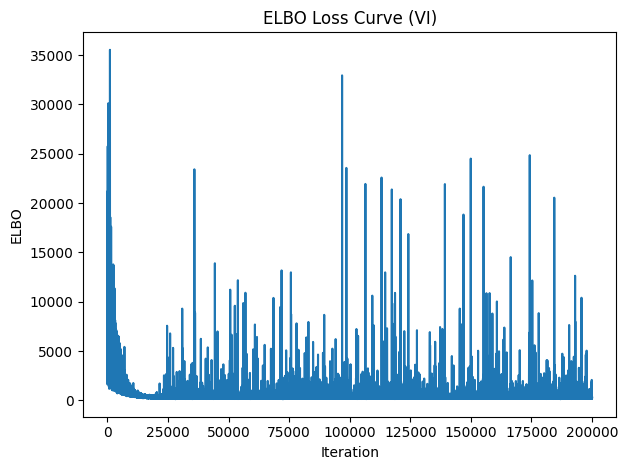

In [16]:
# --------------------------
# ELBO Plot for VI
# --------------------------
plt.plot(approx.hist)
plt.title("ELBO Loss Curve (VI)")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.tight_layout()
plt.show()

In [17]:
az.to_netcdf(trace_vi, "trace_vi.nc")

'trace_vi.nc'